In [1]:
from transformers import RobertaTokenizer, RobertaModel

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
import re

for name, param in model.named_parameters():
    
    #bottom 6 layer freeze
    if name.startswith('encoder.layer'):
        if int(re.search(r'\d+', name).group()) < 6:
            param.requires_grad = False

In [3]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)
    #정상적으로 freeze 됨

embeddings.word_embeddings.weight True
embeddings.position_embeddings.weight True
embeddings.token_type_embeddings.weight True
embeddings.LayerNorm.weight True
embeddings.LayerNorm.bias True
encoder.layer.0.attention.self.query.weight False
encoder.layer.0.attention.self.query.bias False
encoder.layer.0.attention.self.key.weight False
encoder.layer.0.attention.self.key.bias False
encoder.layer.0.attention.self.value.weight False
encoder.layer.0.attention.self.value.bias False
encoder.layer.0.attention.output.dense.weight False
encoder.layer.0.attention.output.dense.bias False
encoder.layer.0.attention.output.LayerNorm.weight False
encoder.layer.0.attention.output.LayerNorm.bias False
encoder.layer.0.intermediate.dense.weight False
encoder.layer.0.intermediate.dense.bias False
encoder.layer.0.output.dense.weight False
encoder.layer.0.output.dense.bias False
encoder.layer.0.output.LayerNorm.weight False
encoder.layer.0.output.LayerNorm.bias False
encoder.layer.1.attention.self.query.weig

## document_stats 정보 가져오기

In [4]:
#데이터 불러와보기
import os
import pandas as pd 
import sqlite3

data_dir = "/data/chaos8527/server14/newsedits_data/matched-sentences/"

os.listdir(data_dir)

['dailymail-matched-sentences.db.gz',
 'torontostar-matched-sentences.db.gz',
 'canadaland-matched-sentences.db.gz',
 'lapresse-matched-sentences.db.gz',
 'telegraph-matched-sentences.db.gz',
 'cbc-matched-sentences.db.gz',
 'independent-matched-sentences.db.gz',
 'wp-matched-sentences.db.gz',
 'reuters-matched-sentences.db.gz',
 '.DS_Store',
 'globemail-matched-sentences.db.gz',
 'ap-matched-sentences.db',
 'guardian-matched-sentences.db.gz',
 'fox-matched-sentences.db.gz',
 'bbc-2-matched-sentences.db.gz',
 'calgaryherald-matched-sentences.db.gz',
 'nationalpost-matched-sentences.db.gz',
 'nyt-matched-sentences.db.gz']

In [332]:
conn_trial = sqlite3.connect(data_dir + "dailymail-matched-sentences.db.gz")

In [5]:
conn = sqlite3.connect(data_dir + 'ap-matched-sentences.db')

In [6]:
conn

In [7]:
pd.read_sql('''SELECT 
                    name
                FROM 
                    sqlite_master 
                WHERE 
                    type ='table' AND 
                    name NOT LIKE 'sqlite_%';
''', con=conn)

,name
0,matched_sentences
1,split_sentences
2,doc_level_stats


In [9]:
pd.read_sql('select * from doc_level_stats', con=conn).head()

,entry_id,version_x,version_y,mean x dist,mean y dist,num_unchanged,num_edited_x,num_edited_y,num_deleted,num_added,num_merged,num_split,num_sentences_x,num_sentences_y,num_refactors,mean_dist_overall
0,1,0,1,0.011069,0.020067,26,19,20,0,1,0,1,45,47,0,0.015568
1,1,1,2,0.040247,0.039950,19,20,20,8,4,1,1,47,43,1,0.040099
2,2,0,1,0.008678,0.008655,20,19,19,1,1,0,0,40,40,0,0.008666
3,2,1,2,0.015470,0.015509,37,3,3,0,0,0,0,40,40,0,0.015489
4,2,2,3,NaN,NaN,0,0,0,33,69,0,0,33,69,0,NaN


In [11]:
doc_level_stats_df = pd.read_sql('select * from doc_level_stats', con=conn)
doc_level_stats_df.shape[0]

61518

<AxesSubplot:>

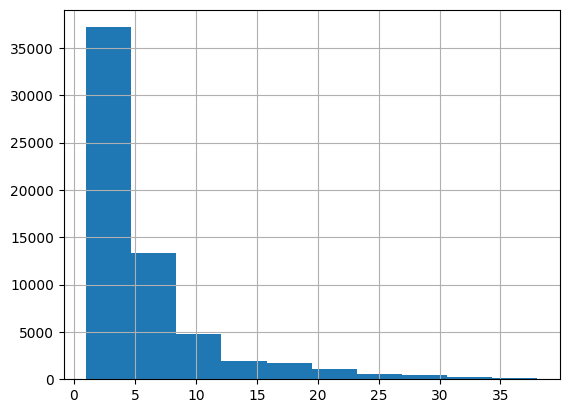

In [83]:
#version 개수 histogram

doc_level_stats_df['version_y'].hist()
    #논문의 설정처럼 sent의 개수가 5개 이상 15개 이하인 경우 + version number가 20개 미만인 경우에 한해서 filtering을 진행하는게 좋을 것
    #train, val, test split은 그냥 랜덤으로...

In [147]:
#논문의 sentence, version 개수 고려한 filtering 진행하기

#version filtering
ver_mask = (doc_level_stats_df.version_y < 20)
filtered_doc_stats = doc_level_stats_df.loc[ver_mask]

#sentence filtering
sent_mask = (filtered_doc_stats.num_sentences_y >= 5) & (filtered_doc_stats.num_sentences_y <= 15)
filtered_doc_stats = filtered_doc_stats.loc[sent_mask]
filtered_doc_stats = filtered_doc_stats.reset_index(drop = True)

In [148]:
filtered_doc_stats.shape

(11154, 16)

In [90]:
doc_level_stats_df.loc[doc_level_stats_df.entry_id == 4].head()
#필터링에 의해서 앞 버전 내용이 짤린 것을 확인할 수 있음

,entry_id,version_x,version_y,mean x dist,mean y dist,num_unchanged,num_edited_x,num_edited_y,num_deleted,num_added,num_merged,num_split,num_sentences_x,num_sentences_y,num_refactors,mean_dist_overall
5,4,0,1,0.046816,0.046816,10,6,6,0,3,0,0,16,19,0,0.046816
6,4,1,2,0.061029,0.039039,10,8,7,2,5,1,0,20,22,1,0.050034
7,4,2,3,0.207115,0.229423,3,15,17,5,7,0,2,23,27,0,0.218269
8,4,3,4,0.014479,0.028138,20,9,10,0,2,0,1,29,32,1,0.021309
9,4,4,5,0.033968,0.033968,26,6,6,1,1,0,0,33,33,0,0.033968


In [149]:
filtered_doc_stats
    #version_x의 수가 0이 아닌 부분부터 시작한다면?...
    #이에 관한 레이블링 정보는?

,entry_id,version_x,version_y,mean x dist,mean y dist,num_unchanged,num_edited_x,num_edited_y,num_deleted,num_added,num_merged,num_split,num_sentences_x,num_sentences_y,num_refactors,mean_dist_overall
0,4,11,12,2.459200e-01,2.461260e-01,1,5,5,13,7,0,0,19,13,1,2.460230e-01
1,4,12,13,2.416777e-01,2.907917e-01,1,2,3,9,4,0,1,12,8,1,2.662347e-01
2,4,13,14,2.708170e-01,2.707080e-01,1,4,4,4,7,0,0,9,12,0,2.707625e-01
3,4,14,15,1.817005e-01,1.819137e-01,1,2,2,9,4,0,0,12,7,0,1.818071e-01
4,4,15,16,3.773336e-01,3.750725e-01,0,5,5,2,8,0,0,7,13,0,3.762031e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11149,23018,0,1,1.290308e-01,1.775770e-01,2,3,4,0,2,0,1,5,8,0,1.533039e-01
11150,23075,0,1,5.124967e-08,5.124967e-08,11,2,2,0,2,0,0,13,15,0,5.124967e-08
11151,23075,1,2,9.231230e-02,9.208693e-02,8,6,6,1,1,1,1,15,15,1,9.219962e-02
11152,23076,0,1,1.249977e-02,1.249977e-02,5,1,1,0,0,0,0,6,6,0,1.249977e-02


In [122]:
filtered_doc_stats.iloc[uniq_values[1][1]:uniq_values[1][2]]

,entry_id,version_x,version_y,mean x dist,mean y dist,num_unchanged,num_edited_x,num_edited_y,num_deleted,num_added,num_merged,num_split,num_sentences_x,num_sentences_y,num_refactors,mean_dist_overall
41,5,5,6,0.402207,0.338945,0,5,1,35,8,4,0,40,9,0,0.370576
42,5,6,7,0.244841,0.272071,1,4,5,4,5,0,1,9,11,1,0.258456
50,5,14,15,0.298008,0.359622,0,3,2,27,7,2,1,30,9,1,0.328815
51,5,15,16,NaN,NaN,0,0,0,7,5,0,0,7,5,0,NaN
52,5,16,17,0.000000,0.000000,5,0,0,0,0,0,0,5,5,0,0.000000


In [150]:
filt_entry_ids = filtered_doc_stats['entry_id'].tolist()

filt_versions = filtered_doc_stats.loc[:, 'version_x':'version_y'].values.tolist()

In [151]:
len([filt_entry_ids.index(x) for x in sorted(set(filt_entry_ids))])

3961

In [152]:
import numpy as np

uniq_ids, uniq_indexs = np.unique(filt_entry_ids, return_index=True)

In [137]:
#유일한 entry_id의 개수
uniq_ids.shape

(3961,)

In [146]:
uniq_ids[-5:]

array([23006, 23018, 23075, 23076, 23078])

In [138]:
#entry_id 출현 index
#이를 가지고 entry_id 별 간격을 설정할 수 있음
uniq_indexs.shape

(3961,)

In [162]:
#entry_id별 index의 집합
test = [filt_versions[uniq_indexs[i]:uniq_indexs[i+1]] if i+1 != len(uniq_indexs) else filt_versions[uniq_indexs[i]:] for i in range(len(uniq_indexs))]

In [210]:
#하나의 index list로
from itertools import chain

indexes = [list(set(list(chain(*x)))) for x in test]

In [201]:
indexes[:5]

[[11, 12, 13, 14, 15, 16, 17, 18],
 [5, 6, 7, 14, 15, 16, 17],
 [2, 3],
 [1, 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [3, 4, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]]

In [211]:
#min이 0이 아닌 경우에 바로 앞 인덱스를 추가

final_indexs = [list(set(x + [min(x)-1])) if min(x) > 0 else x for x in indexes]
    #앞 인덱스를 추가하는 이유는 그 다음 인덱스의 라벨값을 구하기 위함

In [212]:
#key를 entry_id, value는 versions

final_indexs[:5]
    #맨 앞자리는 추적할 수 있는데 중간에 끊어진 경우는 어떻게 찾지?

[[10, 11, 12, 13, 14, 15, 16, 17, 18],
 [4, 5, 6, 7, 14, 15, 16, 17],
 [1, 2, 3],
 [0, 1, 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [2, 3, 4, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]]

In [229]:
trial = final_indexs[3]

In [231]:
trial_np = np.array([trial[i+1] - trial[i] for i in range(len(trial)) if not i+1 == len(trial)])

In [236]:
np.where(np.array(list(range(5))) > 2)[0].tolist()

[3, 4]

In [233]:
np.where(trial_np > 1)[0]

array([2])

In [246]:
y_label_indexs = []

for values in final_indexs:
    
    diffs = []
    new_vals = []
    for i in range(len(values)):
        
        if not i+1 == len(values):
            
            diffs.append(values[i+1] - values[i])
    
    diff_indexs = np.where(np.array(diffs) > 1)[0].tolist()
    
    if len(diff_indexs) > 1:
        
        for index in diff_indexs:
            new_vals.append(values[index+1] -1)
            
        y_label_indexs.append(list(set(values+new_vals)))
        
    else:
        y_label_indexs.append(values)

In [249]:
final_indexs[:5]

[[10, 11, 12, 13, 14, 15, 16, 17, 18],
 [4, 5, 6, 7, 14, 15, 16, 17],
 [1, 2, 3],
 [0, 1, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [2, 3, 4, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]]

In [248]:
y_label_indexs[:5]

[[10, 11, 12, 13, 14, 15, 16, 17, 18],
 [4, 5, 6, 7, 14, 15, 16, 17],
 [1, 2, 3],
 [0, 1, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]]

In [226]:
trial.insert(3, 9)

In [227]:
trial

[0, 1, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [ ]:
final_final_indexs = [list(set(x + [min(x)-1])) if min(x) > 0 else x for x in indexes ]

In [213]:
len(uniq_ids)

3961

In [214]:
len(final_indexs)

3961

In [215]:
#default dict 생성
#key는 entyr_id, value는 versions
id_versions = {id_:version for id_,version in zip(uniq_ids, final_indexs)}

In [216]:
len(id_versions)

3961

In [250]:
y_label_id_versions = {id_:version for id_,version in zip(uniq_ids, y_label_indexs)}

## sentence 정보 가져오기

In [12]:
matched_sentences = pd.read_sql('select * from matched_sentences', con=conn)

In [16]:
sentences = pd.read_sql('select * from split_sentences', con=conn)

In [17]:
sentences.head()

,entry_id,version,sent_idx,sentence
0,17808,4.0,0,<p> ATLANTA (AP) -- Bobby Brown often broke in...
1,17808,4.0,1,"</p> <p>""You never really get over it,"" he sai..."
2,17808,4.0,2,She died at the age of 22 after six months in ...
3,17808,4.0,3,</p> <p>Sporting a gold pendant with a picture...
4,17808,4.0,4,She is also the daughter of the Whitney Housto...


In [18]:
sentences.shape

(2385991, 4)

In [19]:
sentences.entry_id.value_counts()

12239    4160
13731    3666
3902     3355
2167     3351
12267    3320
         ... 
18675       8
11835       8
21809       8
3560        7
8707        4
Name: entry_id, Length: 12841, dtype: int64

In [20]:
sentences.loc[sentences['entry_id'] == 1]

,entry_id,version,sent_idx,sentence
785052,1,2.0,0,<p> WASHINGTON (AP) -- Embracin...
785053,1,2.0,1,</p> <p>Obama became the president to have gra...
785054,1,2.0,2,"Manning, the transgender Army intelligence ana..."
785055,1,2.0,3,</p> <p>Receiving pardons from the president w...
785056,1,2.0,4,"James Cartwright, who was charged with making ..."
...,...,...,...,...
1451975,1,0.0,40,</p> <p>White House officials said neither Ass...
1451976,1,0.0,41,The officials briefed reporters on condition o...
1451977,1,0.0,42,</p> <p>Any action that Justice Department off...
1451978,1,0.0,43,</p> <p>---</p> <p>Associated Press writers Vi...


In [25]:
#entry_id가 빠르고 
sorted_sentences = sentences.sort_values(['entry_id', 'version'], 
                                        ascending = [True, True])
sorted_sentences = sorted_sentences.reset_index(drop=True)

In [73]:
sorted_sentences.iloc[130:136]

,entry_id,version,sent_idx,sentence
130,1,2.0,38,"Following Obama's announcement about Manning, ..."
131,1,2.0,39,</p> <p>White House officials said neither Ass...
132,1,2.0,40,The officials briefed reporters on condition o...
133,1,2.0,41,</p> <p>---</p> <p>Associated Press writers Vi...
134,1,2.0,42,</p>
135,2,0.0,0,<p> WASHINGTON (AP) -- Traditio...


In [ ]:
#id_versions를 이용하여 filtering하기

sorted_sentences.

## 주어져야 하는 데이터 형식
- split_sentences로부터 document를 생성하고
- 해당 document마다 num_deleted, num_added, (num_merged + num_splited), num_refactors를 기록
- label마다 multicalassification 형식으로 제공 (논문처럼 0이상 1미만은 0, 0이상 3미만은 1, 3이상은 2로 기록)

### 질문
- version 0 => version 1 형식으로 레이블링이 되어 있는데 이 부분은 어떻게 고려하여서 train, test, split을 진행하지?....
- train은 아래 version이 많도록 sampling되고 val, test는 최신 version이 많도록 sampling을 하면 되나?
- 그냥 수집하는 데이터 필터링만 논문에서 제시하는대로 하고 그 다음의 train, val, test split은 랜덤하게...

### num_additions만 한정해서 진행해보자

In [74]:
#문서 단위로 추출하기
from tqdm.notebook import tqdm

entry_ids = []
versions = []
documents = []

temp = []
entry_id = 1
version = float(0)

for row in tqdm(sorted_sentences.iterrows(), total = sorted_sentences.shape[0]):
        
    #entry_id가 달라지는 경우
    if entry_id != row[1]['entry_id']:
        documents.append(temp)
        entry_ids.append(entry_id)
        versions.append(version)
        temp = []
        version = row[1]['version']
        entry_id = row[1]['entry_id']
        temp.append(row[1]['sentence'])
    
    #entry_id는 같고 version만 다른 경우
    elif row[1]['version'] != version and row[1]['entry_id'] == entry_id:
        entry_ids.append(entry_id) #현재의 entry_id
        versions.append(version) #현재까지 작업한 버전
        documents.append(temp)
        temp = []
        temp.append(row[1]['sentence'])
        version = row[1]['version']
        
    #entry_id와 version이 동일한 경우
    else:
        temp.append(row[1]['sentence'])

  0%|          | 0/2385991 [00:00<?, ?it/s]

In [75]:
print(len(entry_ids))
print(len(versions))
print(len(documents))

74363
74363
74363


In [76]:
entry_ids[:10]

[1, 1, 1, 2, 2, 2, 2, 4, 4, 4]

In [77]:
versions[:10]

[0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 3.0, 0.0, 1.0, 2.0]

### y_label_id_versions 이용하여 데이터 가져오기

In [281]:
#pd concat 형식으로 데이터 붙이기?

pds = []

for entry_id, versions in tqdm(y_label_id_versions.items()):
    
    floated_versions = [float(x) for x in versions]
    #먼저 entry_id만 추출
    df = sorted_sentences.loc[sorted_sentences.entry_id == entry_id]
    df_vers = df.loc[df.version.isin(floated_versions)]
        
    #versions마다 iter 하면서 sentence 합치기
    uniq_vers = df_vers.version.unique().tolist()
    
    for ver in uniq_vers:
        
        uniq_ver_df = df_vers.loc[df_vers.version == ver]
        
        uniq_ver_sents = "".join(uniq_ver_df.sentence.values.tolist())
        
        raw_val = [[entry_id, ver, uniq_ver_sents]]
        
        df = pd.DataFrame(raw_val, columns = ['entity_id', 'version', 'sentence'])
        pds.append(df)
    

  0%|          | 0/3961 [00:00<?, ?it/s]

In [297]:
final_df = pd.concat(pds)

In [298]:
final_df.shape

(18603, 3)

In [301]:
final_df.head(10)

,entity_id,version,sentence
0,4,10.0,<p> HOUSTON (AP) -- Doctors treating former Pr...
0,4,11.0,<p> HOUSTON (AP) -- Former President George H....
0,4,12.0,<p> HOUSTON (AP) -- Doctors removed former Pre...
0,4,13.0,<p> HOUSTON (AP) -- A spokesman for former Pre...
0,4,14.0,<p> HOUSTON (AP) -- Former President George H....
0,4,15.0,<p> HOUSTON (AP) -- A spokesman says former Pr...
0,4,16.0,<p> HOUSTON (AP) -- Former President George H....
0,4,17.0,<p> HOUSTON (AP) -- Doctors treating former Pr...
0,4,18.0,<p> HOUSTON (AP) -- Former first lady Barbara ...
0,5,4.0,<p> WASHINGTON (AP) -- Offering...


In [305]:
#labeling 하기

id_queries = final_df.entity_id.values.tolist()

ver_queries = final_df.version.values.tolist()

In [321]:
#1 이하이면 0, 1이상 3이하이면 2, 3초과면 3

id_mask = (doc_level_stats_df.entry_id == id_queries[0])

ver_mask = (doc_level_stats_df.version_y == int(ver_queries[0]))

doc_level_stats_df.loc[id_mask & ver_mask]['num_added'].values.item()

4

In [311]:
filtered_doc_stats.loc[id_mask]

,entry_id,version_x,version_y,mean x dist,mean y dist,num_unchanged,num_edited_x,num_edited_y,num_deleted,num_added,num_merged,num_split,num_sentences_x,num_sentences_y,num_refactors,mean_dist_overall
0,4,11,12,0.245920,0.246126,1,5,5,13,7,0,0,19,13,1,0.246023
1,4,12,13,0.241678,0.290792,1,2,3,9,4,0,1,12,8,1,0.266235
2,4,13,14,0.270817,0.270708,1,4,4,4,7,0,0,9,12,0,0.270762
3,4,14,15,0.181701,0.181914,1,2,2,9,4,0,0,12,7,0,0.181807
4,4,15,16,0.377334,0.375073,0,5,5,2,8,0,0,7,13,0,0.376203
5,4,16,17,0.294028,0.293900,1,4,4,10,9,0,0,15,14,0,0.293964
6,4,17,18,0.092071,0.101591,5,6,7,3,3,0,1,14,15,1,0.096831


In [326]:
labels = []

for id_query, ver_query in tqdm(zip(id_queries, ver_queries), total = len(id_queries)):
    
    if ver_query == 0:
        labels.append(0)
        continue
    
    id_mask = (doc_level_stats_df.entry_id == id_query)

    ver_mask = (doc_level_stats_df.version_y == int(ver_query))
    
    num_additions = doc_level_stats_df.loc[id_mask & ver_mask]['num_added'].values.item()
    
    if num_additions >= 0 and num_additions < 1:
        label = 0
        
    elif num_additions >= 1 and num_additions < 3:
        label = 1
        
    else:
        label = 2
        
    labels.append(label)

0it [00:00, ?it/s]

In [329]:
labels[:20]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2]

In [330]:
final_df['label'] = labels

In [331]:
final_df.head()

,entity_id,version,sentence,label
0,4,10.0,<p> HOUSTON (AP) -- Doctors treating former Pr...,2
0,4,11.0,<p> HOUSTON (AP) -- Former President George H....,2
0,4,12.0,<p> HOUSTON (AP) -- Doctors removed former Pre...,2
0,4,13.0,<p> HOUSTON (AP) -- A spokesman for former Pre...,2
0,4,14.0,<p> HOUSTON (AP) -- Former President George H....,2


In [336]:
np.nan

nan